### Neural Network with Sigmoid for Regression

Three-layer neural network for regression tasks using Sigmoid activation function

In [607]:
import numpy as np
import matplotlib.pyplot as plt

class NeuralNetwork():
    def __init__(self, inputLayerSize, hiddenLayerSize, outputLayerSize):
        self.inputLayerSize = inputLayerSize 
        self.hiddenLayerSize = hiddenLayerSize 
        self.outputLayerSize = outputLayerSize 
        
        # Initialize Weights
        self.Wh = 0.01 * np.random.randn(inputLayerSize, hiddenLayerSize)/np.sqrt(inputLayerSize)
        self.Wo = 0.01 * np.random.randn(hiddenLayerSize, outputLayerSize)/np.sqrt(hiddenLayerSize)
        print (self.Wh, self.Wo)
        
        # Initialize Biases
        self.Bh = np.zeros((1, hiddenLayerSize))
        self.Bo = np.zeros((1, outputLayerSize))
        
        # Normalized Data Range
        self.minNorm = 0
        self.maxNorm = 1
        
        # Weighted Inputs
        self.Zh = None
        self.Zo = None
        
        # Activations
        self.Ah = None
        self.Ao = None
        self.output = self.Ao
        
    def normalize(self, X, newMin, newMax):
        curMin = np.amin(X, axis=0)
        curMax = np.amax(X, axis=0)
        curRange = (curMax - curMin)  
        newRange = (newMax - newMin)
        return (((X - curMin) * newRange) / curRange) + newMin

    def denormalize(self, normalized, oldMin, oldMax):
        return normalize(normalized, oldMin, oldMax)

    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def sigmoidGradient(self,z):
        #http://mathworld.wolfram.com/SigmoidFunction.html
        #Z = WeightedInput to the CurrentLayer
        #We could alternatively pass in the Activation value
        #At which point the formula would become Activation*(1-Activation)
        #np.exp(-z)/((1+np.exp(-z))**2)
        return self.sigmoid(z)*(1-self.sigmoid(z))
    
    def cost(self, X, y):
        output = self.feed_forward(X)
        cost = np.sum((output-y)**2) / 2.0
        return cost
    
    def costGradient(self, output, y):
        return output - y
    
    def dCdW(self, layer_input, layer_error):
        #Derivative of Cost with respect to any weight in the network
        return np.dot(layer_input.T, layer_error)
            
    def dCdB(self, curLayerError):
        #Derivative of Cost with respect to the Bias of any neuron in the network
        '''
        CurLayerError has one row for each observation in our training set.
        This is fine for dCdW because the matrix multiplication takes
        care of transforming the output into dimensions that
        equal our weight dimensions (so we can subtract).
        However bias isn't multiplied by anything so we're stuck with 
        the dimensions of the output error. To fix this take the sum of
        all the output errors across observations (we could also take the average
        but our learning rate will handle scaling this value appropriately).
        The operation below sums all the values in a matrix on the row axis (0).
        It's essentially like summing all the rows into a single row. The column
        dimensions remain unchanged.
        '''
        return np.sum(curLayerError, axis=0, keepdims=True)
    
    def feed_forward(self, X):
        self.Zh = np.dot(X, self.Wh) + self.Bh
        self.Ah = self.sigmoid(self.Zh)
        self.Zo = np.dot(self.Ah, self.Wo) + self.Bo
        self.Ao = self.sigmoid(self.Zo) #network output
        return self.Ao
    
    def backprop(self, X, output, y):
        err_output = self.costGradient(output, y) * self.sigmoidGradient(self.Zo)
        err_hidden = np.dot(err_output, self.Wo.T) * self.sigmoidGradient(self.Zh)
        
        # Weight Gradients
        dCdWh = self.dCdW(X, err_hidden)
        dCdWo = self.dCdW(self.Ah, err_output)
        
        # Bias Gradients
        dCdBh = self.dCdB(err_hidden)
        dCdBo = self.dCdB(err_output)

        return dCdWh, dCdWo, dCdBh, dCdBo
    
    def update_weights(self, X, y, lr):
        output = self.feed_forward(X)
        dCdWh, dCdWo, dCdBh, dCdBo = self.backprop(X, output, y)
        
        # Update Weights
        self.Wh -= lr * dCdWh
        self.Wo -= lr * dCdWo
        
        # Update Biases
        self.Bh -= lr * dCdBh
        self.Bo -= lr * dCdBo
    
        cost = self.cost(X, y)
        return cost

    def train(self, X, y, epochs, lr, log_interval):
        X = self.normalize(X, self.minNorm, self.maxNorm)
        y = self.normalize(y, self.minNorm, self.maxNorm)
        cost_history = []
        for epoch in range(1,epochs+1):
            self.log("Epoch %d ---------------" % epoch, epoch, log_interval)
            cost = self.update_weights(X, y, lr)
            cost_history.append(cost)
            msg = "Cost:" + str(round(cost,5)) + "\n"
            self.log(msg, epoch, log_interval)
        return cost_history
    
    def predict(self, X, y_min, y_max):
        normalized_input = self.normalize(X, self.minNorm, self.maxNorm)
        output = self.feed_forward(normalized_input)
        denormalized_output = self.denormalize(output, y_min, y_max)
        return denormalized_output
    
    def log(self, msg, epoch, log_interval):
        if epoch % log_interval == 0:
            print(msg)

### Visualize

In [608]:
def graph(x, y, xlabel="X", ylabel="Y", title="X vs Y"):
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
def graph_error(error_history):
    iterations = [i for i in range(1,len(error_history)+1)]
    plt.plot(iterations, error_history)
    plt.title('Error Rate')
    plt.xlabel('Training Iterations')
    plt.ylabel('Mean Squared Error')
    plt.show()

### Load Data

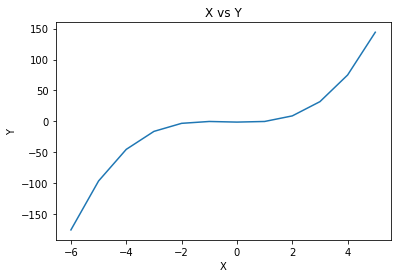

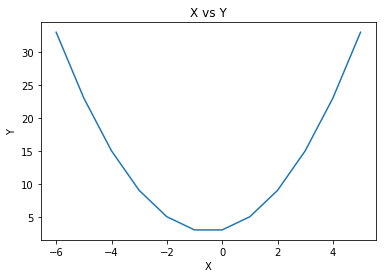

In [609]:
def quadratic(x):
    return x**2 + x + 3

def get_quadratic_data(start=-6,end=6):
    X = np.array([i for i in range(start,end)], dtype="float64")    
    X.shape = (len(X),1)
    
    y = np.array([quadratic(X[i]) for i in range(len(X))], dtype="float64")
    y.shape = (len(y),1)
    
    return X, y

def cubic(x):
    return x**3 + x**2 - x - 1

def get_cubic_data(start=-6,end=6):
    X = np.array([i for i in range(start,end)], dtype="float64")    
    X.shape = (len(X),1)
    
    y = np.array([cubic(X[i]) for i in range(len(X))], dtype="float64")
    y.shape = (len(y),1)
    
    return X, y

cX, cy = get_cubic_data()
graph(cX,cy)

qX, qy = get_quadratic_data()
graph(qX,qy)

### Training

In [616]:
X,y = get_quadratic_data(-20,21)
X,y = get_cubic_data(-5,6)
nn = NeuralNetwork(1,2,1)

[[ 0.00115943 -0.01139711]] [[-0.00588394]
 [-0.00189702]]


In [ ]:
cost_hist = nn.train(X,y,60000,.1,5000)
print (cost[:3])
print (cost[-3:])

graph_error(cost_hist)

Epoch 5000 ---------------
Cost:0.07147

Epoch 10000 ---------------
Cost:0.06618

Epoch 15000 ---------------
Cost:0.06265

Epoch 20000 ---------------
Cost:0.05869



In [614]:
start,end = (-20,21)

#Quadratic
X,y = get_quadratic_data(start,end)
output = nn.predict(X,y_min=0,y_max=quadratic(max(abs(start), abs(end))))

quadratic(20)

#Cubic
X,y = get_cubic_data(start, end)
output = nn.predict(X,y_min=cubic(start), y_max=cubic(end))

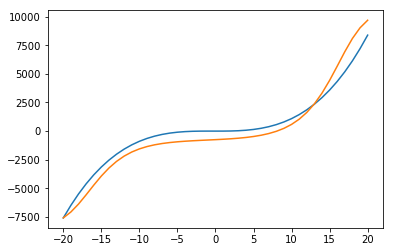

In [615]:
plt.plot(X,y)
plt.plot(X,output)
plt.show()

### Scikit-Learn Example

In [566]:
#https://scikit-neuralnetwork.readthedocs.io/en/latest/module_mlp.html#regressor
from sknn.mlp import Regressor
from sknn.mlp import Layer
hiddenLayer = Layer("Sigmoid", units=3)
outputLayer = Layer("Linear", units=1)
nn = Regressor([hiddenLayer, outputLayer],learning_rule='sgd',learning_rate=.01,
               batch_size=5,loss_type="mse",debug=False,verbose=False,regularize=None)

Initializing neural network with 2 layers, 1 inputs and 1 outputs.
  - Dense: Sigmoid    Units:  3   
  - Dense: Linear     Units:  1   

Training on dataset of 11 samples with 22 total size.
  - Early termination after 10 stable iterations.
    1          2.627e+02                 N/A            0.0s
    2          1.888e+02                 N/A            0.0s
    3          4.005e+02                 N/A            0.0s
    4          1.629e+02                 N/A            0.0s
    5          1.195e+02                 N/A            0.0s
    6          1.068e+02                 N/A            0.0s
    7          1.007e+02                 N/A            0.0s
    8          9.278e+01                 N/A            0.0s
    9          8.761e+01                 N/A            0.0s
   10          8.427e+01                 N/A            0.0s
   11          8.442e+01                 N/A            0.0s
   12          8.229e+01                 N/A            0.0s
   13          9.281e+01  

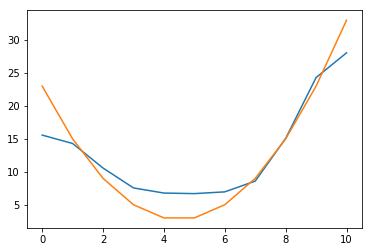

In [567]:
X,y = get_quadratic_data(-5,6)
nn.fit(X,y)
predictions = nn.predict(X)
plt.plot(predictions)
plt.plot(y)
plt.show()